# OneTrickFan - MVP Single Champion
## Single Champion Classification
This is the training to recognize the champion image of a single champion (e.g. Viktor).  

This is our prototype MVP.

---
## Step 1: Setup

In [1]:
CHAMP_NAME="viktor"

In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline



In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [4]:
import fastai
fastai.__version__

'1.0.52'

Check to make sure we are using the GPU.

In [5]:
import torch

print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())


0
1
GeForce RTX 2070
True


In [6]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.vision import *

---
## Step 2: Setup

In [7]:
import os
os.listdir(".")

['Valid',
 'simple',
 'OneTrickFan.ipynb',
 'OneTrickFan-Single.ipynb',
 '.ipynb_checkpoints',
 'models',
 'Train',
 'onetrickfan-simple.pkl']

In [16]:
tfms = get_transforms(flip_vert = False, do_flip = False, max_warp = None, max_rotate = 1)

In [17]:
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-1, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)])

So we ran into a problem - when we went all the way through the pipeline, our model started spitting out matches when obviously none were present.  I think this was probably due to the transforms in training, so we're going to try removing some of them now.

If that doesn't end up working, we'll increase the size from 400 to 600

In [18]:
data = ImageList.from_folder("Train")


In [19]:
b = os.listdir("Train/yes")[:5]
b

['z3I5lXLeMuo103.jpg',
 'A0FMFcQ8bpA87.jpg',
 '3RQNCEM04O0287.jpg',
 'I_YWrAiyKHc267.jpg',
 'o5SToS1nooE63.jpg']

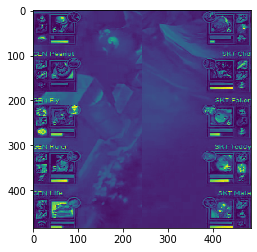

In [20]:
img = mpimg.imread('Train/yes/' + b[0])
imgplot = plt.imshow(img)

- Well this is definitely part of the problem - these images haven't had the production resize applied to them.
- Have to make sure this is the proper cropped version

In [21]:
data = data.split_by_rand_pct()
data = data.label_from_folder()
data = data.transform(tfms, size=484) 
data = data.databunch()
data = data.normalize()

In [22]:
data

ImageDataBunch;

Train: LabelList (14101 items)
x: ImageList
Image (3, 484, 484),Image (3, 484, 484),Image (3, 484, 484),Image (3, 484, 484),Image (3, 484, 484)
y: CategoryList
yes,yes,yes,yes,yes
Path: Train;

Valid: LabelList (3525 items)
x: ImageList
Image (3, 484, 484),Image (3, 484, 484),Image (3, 484, 484),Image (3, 484, 484),Image (3, 484, 484)
y: CategoryList
yes,yes,yes,no,yes
Path: Train;

Test: None

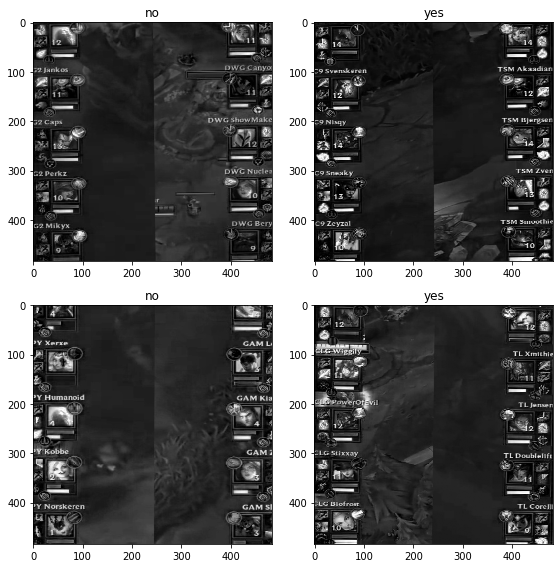

In [23]:
data.show_batch(2, figsize=(8,8), hide_axis=False)

We've left in the light and dark transforms, since I think that will be helpful, especially with the different backgrounds.

---
## Step 3: Model

### Since we've already trained a good amount on the simple model, let's bring it in here.

In [24]:
os.listdir()

['Valid',
 'simple',
 'OneTrickFan.ipynb',
 'OneTrickFan-Single.ipynb',
 '.ipynb_checkpoints',
 'models',
 'Train',
 'onetrickfan-simple.pkl']

In [25]:
from fastai.metrics import error_rate
learn = cnn_learner(data, models.resnet34, metrics=error_rate).to_fp16()
learn.load('../../simple/Train/models/onetrickfan-simple-1')
learn.data.batch_size = 32

In [26]:
learn.data.batch_size

32

We had to bring the batch size down from 64, since our CUDA card couldn't handle it.  Made training a bit slower, but I think the extra resolution will make up for it. 

We ended up unfreezing before running, since we brought in outside weights.  Doing it without unfreezing ended up actually being a couple % points worse performance on the first run (88% vs like 95%)

In [27]:
learn.unfreeze() 
torch.cuda.empty_cache()

In [30]:
defaults.device = torch.device('cuda')
learn.fit_one_cycle(4)

#### Some historical Notes
We had previously had the frozen layers, then run lr_find here.  Since we transferred in these weights, this endedup being unnecessary.

`learn.lr_find()`

`learn.recorder.plot()`

`learn.fit_one_cycle(4)`

In [31]:
learn.save("onetrickfan-" + CHAMP_NAME + "-2")

In [32]:

learn.export("onetrickfan-" + CHAMP_NAME + "-2.pkl")


---
## Step 4: Check the Model

In [33]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate).to_fp16()
learn.load('onetrickfan-' + CHAMP_NAME + '-2')
learn.data.batch_size = 32

In [34]:
from fastai.widgets import *

ds, idxs = DatasetFormatter().from_toplosses(learn)

In [ ]:
ImageCleaner(ds, idxs, "Train") # Beware, this can be REALLY slow.

In [35]:
(ds, idxs)

(LabelList (14101 items)
 x: ImageList
 Image (3, 250, 300),Image (3, 250, 300),Image (3, 250, 300),Image (3, 250, 300),Image (3, 250, 300)
 y: CategoryList
 yes,yes,yes,yes,yes
 Path: Train, tensor([5754, 2782, 4645,  ...,  927, 2044, 6167]))

This is shows the top mislabelled predictions.

In [36]:
interp = ClassificationInterpretation.from_learner(learn)

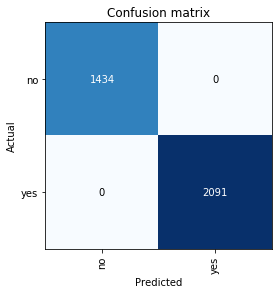

In [37]:
interp.plot_confusion_matrix()

Time for some simple spot checks

In [38]:
os.listdir("Valid")

['yes', 'no']

In [39]:
import glob

(Category yes, tensor(1), tensor([3.3869e-05, 9.9997e-01]))
(Category yes, tensor(1), tensor([1.2007e-04, 9.9988e-01]))
(Category yes, tensor(1), tensor([8.5811e-05, 9.9991e-01]))
(Category yes, tensor(1), tensor([7.8438e-05, 9.9992e-01]))
(Category yes, tensor(1), tensor([1.3394e-04, 9.9987e-01]))
(Category yes, tensor(1), tensor([6.5283e-05, 9.9993e-01]))
(Category yes, tensor(1), tensor([7.0038e-05, 9.9993e-01]))
(Category yes, tensor(1), tensor([4.9279e-05, 9.9995e-01]))
(Category yes, tensor(1), tensor([6.3522e-05, 9.9994e-01]))
(Category yes, tensor(1), tensor([6.7092e-05, 9.9993e-01]))
(Category yes, tensor(1), tensor([6.0613e-05, 9.9994e-01]))
(Category yes, tensor(1), tensor([7.8438e-05, 9.9992e-01]))
(Category yes, tensor(1), tensor([1.1637e-04, 9.9988e-01]))
(Category yes, tensor(1), tensor([7.5433e-05, 9.9992e-01]))
(Category yes, tensor(1), tensor([1.2243e-04, 9.9988e-01]))
(Category yes, tensor(1), tensor([6.4271e-05, 9.9994e-01]))
(Category yes, tensor(1), tensor([1.4710

(Category yes, tensor(1), tensor([2.4251e-04, 9.9976e-01]))
(Category yes, tensor(1), tensor([1.4539e-04, 9.9985e-01]))
(Category yes, tensor(1), tensor([1.6669e-04, 9.9983e-01]))
(Category yes, tensor(1), tensor([4.9279e-05, 9.9995e-01]))
(Category yes, tensor(1), tensor([5.6278e-05, 9.9994e-01]))
(Category yes, tensor(1), tensor([7.1419e-05, 9.9993e-01]))
(Category yes, tensor(1), tensor([4.7022e-05, 9.9995e-01]))
(Category yes, tensor(1), tensor([3.5634e-05, 9.9996e-01]))
(Category yes, tensor(1), tensor([1.2982e-04, 9.9987e-01]))
(Category yes, tensor(1), tensor([1.6998e-04, 9.9983e-01]))
(Category yes, tensor(1), tensor([2.1654e-04, 9.9978e-01]))
(Category yes, tensor(1), tensor([7.0587e-05, 9.9993e-01]))
(Category yes, tensor(1), tensor([6.1089e-05, 9.9994e-01]))
(Category yes, tensor(1), tensor([1.9411e-04, 9.9981e-01]))
(Category yes, tensor(1), tensor([9.0988e-05, 9.9991e-01]))
(Category yes, tensor(1), tensor([6.8149e-05, 9.9993e-01]))
(Category yes, tensor(1), tensor([1.0032

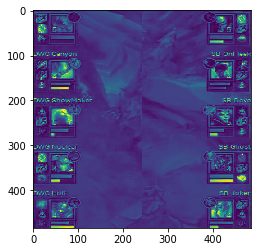

In [40]:
for fname in glob.glob("Valid/yes/*"):
    print(learn.predict(open_image(fname)))
    img = mpimg.imread(fname)
    imgplot = plt.imshow(img)

In [41]:
for fname in glob.glob("Valid/no/*.jpg"):
    print(learn.predict(open_image(fname))[0])

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


Looks good to me!

## Single Champion Model Final Thoughts
I really think upgrading the image size and sacrificing the batch size was well worth it.  The transfer learning had worse results off the bat, but eventually converged on a great solution.   